In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer #needed for data preparation

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS, TSNE
from kneed import KneeLocator
from sklearn.cluster import KMeans


#### Load the data set

In [2]:
df = pd.read_csv("./bank.csv")
df_pre = df.copy()
print('number of examples, number of attributes:', df.shape)

number of examples, number of attributes: (2000, 17)


#### EDA and data preparation

In [3]:
#display the first 5 rows of data
df.head()

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed  
0         no  
1         no  
2         no  
3         no  
4         no

In [4]:
#Display the last 5 rows of data
df.tail()

age           job  marital  education default  balance housing loan  \
1995  20.0       student   single        NaN      no     2785      no   no   
1996  28.0        admin.   single  secondary      no      127      no   no   
1997  81.0       retired  married    primary      no     1154      no   no   
1998  46.0      services  married    primary      no     4343     yes   no   
1999  40.0  entrepreneur  married  secondary      no     6403      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
1995   cellular   16   sep       327         2     -1         0      NaN   
1996   cellular   16   sep      1334         2     -1         0      NaN   
1997  telephone   17   sep       231         1     -1         0      NaN   
1998        NaN   20   sep       185         1     -1         0      NaN   
1999   cellular   22   sep       208         2     -1         0      NaN   

     subscribed  
1995        yes  
1996        yes  
1997        yes  
1998        yes  
1999        yes

In [5]:
#Display metrics on numberical data 
df.describe()

age       balance          day     duration     campaign  \
count  1988.000000   2000.000000  2000.000000  2000.000000  2000.000000   
mean     41.753018   1413.663500    13.851500   292.020500     1.909500   
std      12.724358   3131.224213     9.712189   221.557295     1.378862   
min      18.000000   -980.000000     1.000000     7.000000     1.000000   
25%      32.000000    201.500000     5.000000   146.000000     1.000000   
50%      38.000000    551.000000    12.000000   236.000000     1.000000   
75%      50.000000   1644.500000    23.000000   379.000000     2.000000   
max      93.000000  81204.000000    31.000000  1823.000000    11.000000   

             pdays     previous  
count  2000.000000  2000.000000  
mean    167.896000     2.561500  
std     131.754126     3.400735  
min      -1.000000     0.000000  
25%      75.750000     1.000000  
50%     182.000000     2.000000  
75%     251.000000     3.000000  
max     854.000000    55.000000

There 2000 rows in the data set each representing a customer of the bank. There are 7 attributes that represent numerical data. Of the 7 numerical columns, there is only one that is missing data. The age attribute is missing 12 values. 

Most of the data is left skewed. Both day and pdays appear binomial with two distinct peaks. Pdays is also left skewed so it may be worth tackling the skew and see if the binomial still exists. Balance looks to have a lot of values around zero which could be legitimate or else missing data represented as zeros.



<Axes: >

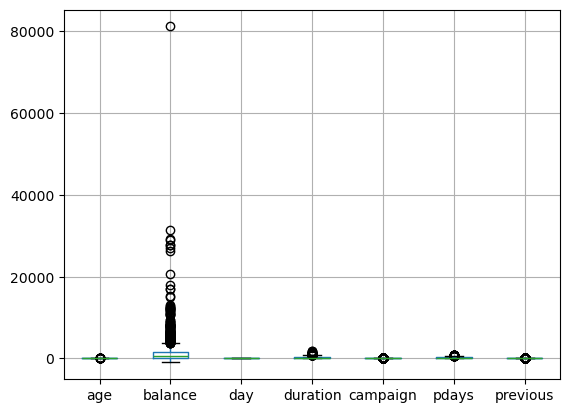

In [6]:

df.boxplot()

Balance has significant outliers that impact the scale of the other attributes when represented together in the boxplot. The other attributes also have outliers with the exception of days which can be mapped since there are no more than 31 days in a month. For all attributes that have outliers, the robust scalar will be used. 

In [7]:
# maps abbreviated month names
month_mapper = {
    "jan": 1,
    "feb": 2,
    "mar": 3,
    "apr": 4,
    "may": 5,
    "jun": 6,
    "jul": 7,
    "aug": 8,
    "sep": 9,
    "oct": 10,
    "nov": 11,
    "dec": 12
}
#maps education levels 
edu_level_mapper = {
    "primary": 1,
    "secondary": 2,
    "tertiary": 3,
    "education_unknown": 4
}
# maps binary values 
binary_mapper = {
    "yes": 1,
    "no": 0
}



def encode(df):
    '''Takes the data frame as the argument and performs the mapping for specific columns in the DataFrame
    '''
    df['month'] = df['month'].replace(month_mapper)
    df['education'] = df['education'].replace(edu_level_mapper)
    df['default'] = df['default'].replace(binary_mapper)
    df['housing'] = df['housing'].replace(binary_mapper)
    df['loan'] = df['loan'].replace(binary_mapper)
    df['subscribed'] = df['subscribed'].replace(binary_mapper)

    return df

def cyclic_encoder(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col +'_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

df_pre = encode(df_pre)

df_pre = cyclic_encoder(df_pre, 'month', 12)
df_pre = cyclic_encoder(df_pre, 'day', 7)

df_pre = df_pre.drop(columns=['month', 'day'])

pd.set_option('display.max_columns', 100)
#encodes the mapping data on the data frame and stores in new data frame name


df_pre


age           job   marital  education  default  balance  housing  \
0     32.0    technician    single        3.0        0      392        1   
1     39.0    technician  divorced        2.0        0      688        1   
2     59.0       retired   married        2.0        0     1035        1   
3     47.0   blue-collar   married        2.0        0      398        1   
4     54.0       retired   married        2.0        0     1004        1   
...    ...           ...       ...        ...      ...      ...      ...   
1995  20.0       student    single        NaN        0     2785        0   
1996  28.0        admin.    single        2.0        0      127        0   
1997  81.0       retired   married        1.0        0     1154        0   
1998  46.0      services   married        1.0        0     4343        1   
1999  40.0  entrepreneur   married        2.0        0     6403        0   

      loan    contact  duration  campaign  pdays  previous poutcome  \
0        0   cellular       957         2    131         2  failure   
1        1   cellular       233         2    133         1  failure   
2        1   cellular       126         2    239         1  failure   
3        1   cellular       274         1    238         2  failure   
4        0   cellular       479         1    307         1  failure   
...    ...        ...       ...       ...    ...       ...      ...   
1995     0   cellular       327         2     -1         0      NaN   
1996     0   cellular      1334         2     -1         0      NaN   
1997     0  telephone       231         1     -1         0      NaN   
1998     0        NaN       185         1     -1         0      NaN   
1999     0   cellular       208         2     -1         0      NaN   

      subscribed  month_sin     month_cos   day_sin   day_cos  
0              0   0.866025 -5.000000e-01  0.781831  0.623490  
1              0   0.866025 -5.000000e-01  0.781831  0.623490  
2              0   0.866025 -5.000000e-01  0.781831  0.623490  
3              0   0.866025 -5.000000e-01  0.781831  0.623490  
4              0   0.866025 -5.000000e-01  0.781831  0.623490  
...          ...        ...           ...       ...       ...  
1995           1  -1.000000 -1.836970e-16  0.974928 -0.222521  
1996           1  -1.000000 -1.836970e-16  0.974928 -0.222521  
1997           1  -1.000000 -1.836970e-16  0.433884 -0.900969  
1998           1  -1.000000 -1.836970e-16 -0.781831  0.623490  
1999           1  -1.000000 -1.836970e-16  0.781831  0.623490  

[2000 rows x 19 columns]

Mapping of categorical features completed outside of the pipeline. The remainder of the transformation will be completed inside the pipeline using the 'df_pre' data frame as the input to the pipeline

In [11]:

#Split the parameters between categorical and numerical
#Subdivide the numerical and categorical to facilitate application of different transformation to different columns
num_a_cols = ['age', 'balance', 'duration', 'campaign', 'previous']

num_b_cols = ['pdays']

num_c_cols = ['month_sin', 'month_cos', 'day_sin', 'day_cos']

cat_a_cols = [ 'education', 'housing', 'default', 'loan', 'subscribed' ]

cat_b_cols = ['job', 'marital', 'contact', 'poutcome']


def log_transform(column):
    min_value = np.min(column)
    return np.log(column + np.abs(min_value) + 1)

num_a_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler()),
    ('distribution_transform', FunctionTransformer(func=log_transform))
])

num_b_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
     ])

num_c_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    
     ])

cat_a_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

cat_b_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

prepro = ColumnTransformer(transformers=[
    ('num_a', num_a_pipeline, num_a_cols),
    ('num_b', num_b_pipeline, num_b_cols),
    ('num_c', num_c_pipeline, num_c_cols),
    ('cat_a', cat_a_pipeline, cat_a_cols),
    ('cat_b', cat_b_pipeline, cat_b_cols),
], remainder='passthrough')

prepro_pipe = Pipeline(steps=[
    ('preprocess', prepro), 
])

transformed_data = prepro_pipe.fit_transform(df_pre)
df_trans = pd.DataFrame(transformed_data)

df_trans

0         1         2         3         4         5         6   \
0     0.575364  0.693609  1.649722  1.134980  0.747214 -0.280107  0.866025   
1     0.773190  0.791205  0.741097  1.134980  0.476924 -0.264923  0.866025   
2     1.187166  0.894668  0.494091  1.134980  0.476924  0.539807  0.866025   
3     0.959776  0.695685  0.821629  0.747214  0.747214  0.532215  0.866025   
4     1.098612  0.885848  1.148681  0.747214  0.476924  1.056049  0.866025   
...        ...       ...       ...       ...       ...       ...       ...   
1995  0.105361  1.297265  0.916958  1.134980  0.105361 -1.282224 -1.000000   
1996  0.441833  0.597340  1.920381  1.134980  0.105361 -1.282224 -1.000000   
1997  1.504077  0.927820  0.736997  0.747214  0.105361 -1.282224 -1.000000   
1998  0.938270  1.555820  0.637754  0.747214  0.105361 -1.282224 -1.000000   
1999  0.798508  1.819140  0.688607  1.134980  0.105361 -1.282224 -1.000000   

                7         8         9    10   11   12   13   14   15   16  \
0    -5.000000e-01  0.781831  0.623490  3.0  1.0  0.0  0.0  0.0  0.0  0.0   
1    -5.000000e-01  0.781831  0.623490  2.0  1.0  0.0  1.0  0.0  0.0  0.0   
2    -5.000000e-01  0.781831  0.623490  2.0  1.0  0.0  1.0  0.0  0.0  0.0   
3    -5.000000e-01  0.781831  0.623490  2.0  1.0  0.0  1.0  0.0  0.0  1.0   
4    -5.000000e-01  0.781831  0.623490  2.0  1.0  0.0  0.0  0.0  0.0  0.0   
...            ...       ...       ...  ...  ...  ...  ...  ...  ...  ...   
1995 -1.836970e-16  0.974928 -0.222521  2.0  0.0  0.0  0.0  1.0  0.0  0.0   
1996 -1.836970e-16  0.974928 -0.222521  2.0  0.0  0.0  0.0  1.0  1.0  0.0   
1997 -1.836970e-16  0.433884 -0.900969  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
1998 -1.836970e-16 -0.781831  0.623490  1.0  1.0  0.0  0.0  1.0  0.0  0.0   
1999 -1.836970e-16  0.781831  0.623490  2.0  0.0  0.0  0.0  1.0  0.0  0.0   

       17   18   19   20   21   22   23   24   25   26   27   28   29   30  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0   
2     0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
4     0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1995  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0   
1997  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1998  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
1999  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

       31   32   33  
0     1.0  0.0  0.0  
1     1.0  0.0  0.0  
2     1.0  0.0  0.0  
3     1.0  0.0  0.0  
4     1.0  0.0  0.0  
...   ...  ...  ...  
1995  1.0  0.0  0.0  
1996  1.0  0.0  0.0  
1997  1.0  0.0  0.0  
1998  1.0  0.0  0.0  
1999  1.0  0.0  0.0  

[2000 rows x 34 columns]

In [12]:
#check if any missing values remain after transform
df_trans.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
dtype: int64

C:\Users\KOFarre1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\KOFarre1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\KOFarre1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\KOFarre1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.p

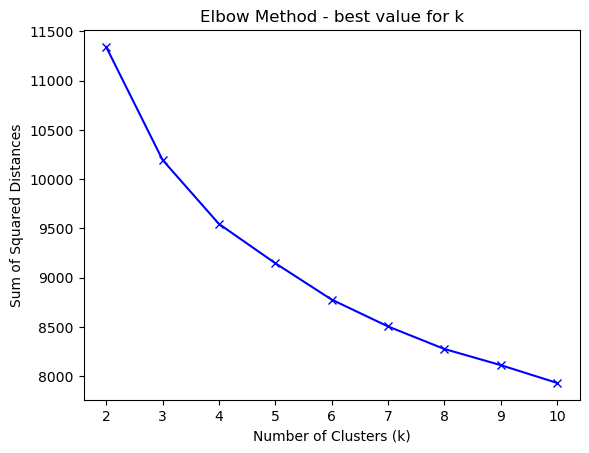

In [13]:
# set range of K values to test
k_values = range(2, 11)

# list to store the sum of squared distances
ssd = []

# Calculate the sum of squared distances for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_trans)
    ssd.append(kmeans.inertia_)

# Plot the values of k against the sum of squared distances
plt.plot(k_values, ssd, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method - best value for k')
plt.show()

Elbow method indicates that the optimum numnber of clusters is approximately 3 or possibly 4. The result is not that clear cut and is open to interpretation. Next compare it with the silhouette score. 

C:\Users\KOFarre1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\KOFarre1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\KOFarre1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\KOFarre1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.p

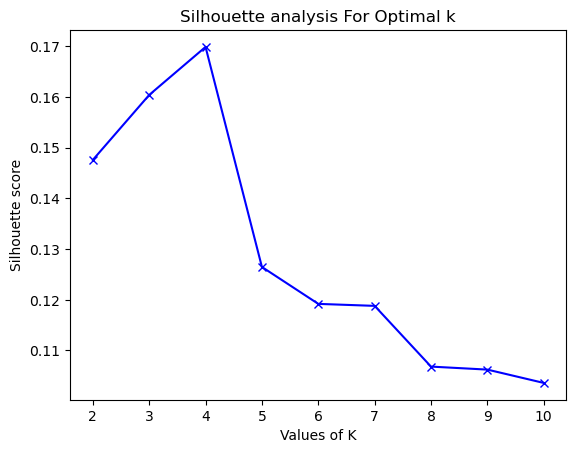

In [14]:

silhouette_avg = []
for num_clusters in k_values:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(df_trans)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(df_trans, cluster_labels))

plt.plot(k_values,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

The silhouette score is maximised at a k value of 4. The higher score indicates better clustering and takes into account cohesion within a cluster and separation between clusters. For the scatterplots of k-means I will try k=3 and k=4 and compare the results.

In [46]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

    plt.show()



In [47]:
# Set the number of clusters
k = 3

# Define a pipeline consisting of preprocessing and k-means clustering
pipe = Pipeline(steps=[
    ('preprocess', prepro_pipe),  # Apply preprocessing steps 
    ('kMeans', cluster.KMeans(n_clusters=k, n_init=10, max_iter=300)) # Use k-means clustering with k clusters
])

In [48]:
#fit the pipeline with the partially pre-processed data frame
clustering_model = pipe.fit(df_pre)

C:\Users\KOFarre1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [49]:
#transform the data
preprocessed_data = clustering_model['preprocess'].transform(df_pre)
preprocessed_data

array([[0.57536414, 0.69360907, 1.64972185, ..., 1.        , 0.        ,
        0.        ],
       [0.77318989, 0.79120459, 0.74109679, ..., 1.        , 0.        ,
        0.        ],
       [1.18716569, 0.89466802, 0.49409125, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [1.5040774 , 0.92782022, 0.73699749, ..., 1.        , 0.        ,
        0.        ],
       [0.93826964, 1.55581976, 0.63775444, ..., 1.        , 0.        ,
        0.        ],
       [0.7985077 , 1.81913971, 0.68860661, ..., 1.        , 0.        ,
        0.        ]])

In [50]:

data_and_centers = np.r_[preprocessed_data,clustering_model['kMeans'].cluster_centers_]

In [51]:
XYcoordinates = manifold.MDS(n_components=2, n_init=10, n_jobs=-1).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


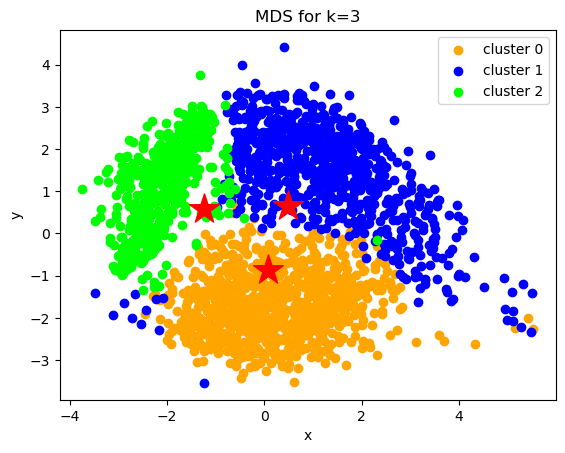

In [52]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title=f'MDS for k={k}')

In [53]:
XYcoordinates = manifold.TSNE(n_components=2, n_iter=8000, perplexity=40, init='pca', n_jobs=-1).fit_transform(data_and_centers)
print("transformation complete")

C:\Users\KOFarre1\AppData\Local\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\KOFarre1\AppData\Local\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


transformation complete


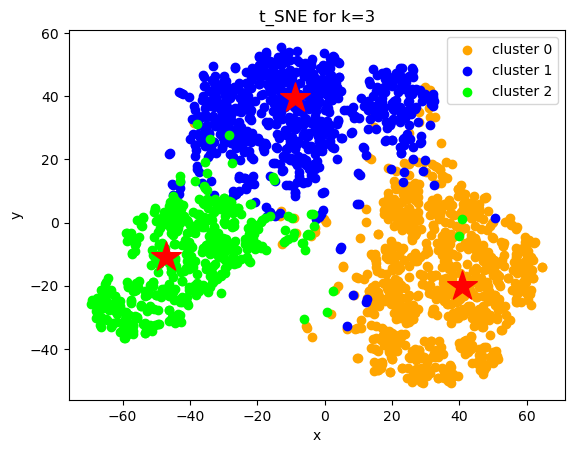

In [54]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_,
                       centers=XYcoordinates[-k:,:], 
                       title=f't_SNE for k={k}')

In [55]:
df['cluster'] = pd.Series(clustering_model['kMeans'].labels_, index=df.index)

In [56]:

# Set the number of clusters
k = 4
# Define a pipeline consisting of preprocessing and k-means clustering
pipe = Pipeline(steps=[
    ('preprocess', prepro_pipe), 
    ('kMeans', cluster.KMeans(n_clusters=k, n_init=10, max_iter=300))
])

In [57]:
clustering_model = pipe.fit(df_pre)

C:\Users\KOFarre1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [58]:
preprocessed_data = clustering_model['preprocess'].transform(df_pre)
preprocessed_data

array([[0.57536414, 0.69360907, 1.64972185, ..., 1.        , 0.        ,
        0.        ],
       [0.77318989, 0.79120459, 0.74109679, ..., 1.        , 0.        ,
        0.        ],
       [1.18716569, 0.89466802, 0.49409125, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [1.5040774 , 0.92782022, 0.73699749, ..., 1.        , 0.        ,
        0.        ],
       [0.93826964, 1.55581976, 0.63775444, ..., 1.        , 0.        ,
        0.        ],
       [0.7985077 , 1.81913971, 0.68860661, ..., 1.        , 0.        ,
        0.        ]])

In [59]:
data_and_centers = np.r_[preprocessed_data,clustering_model['kMeans'].cluster_centers_]

In [60]:
XYcoordinates = manifold.MDS(n_components=2, n_init=20, n_jobs=-1).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


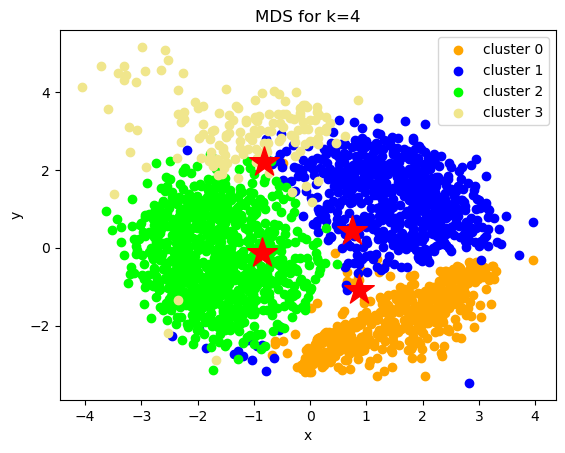

In [61]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title=f'MDS for k={k}')

In [62]:
XYcoordinates = manifold.TSNE(n_components=2, n_iter=8000, perplexity=40, init='pca', n_jobs=-1).fit_transform(data_and_centers)
print("transformation complete")

C:\Users\KOFarre1\AppData\Local\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\KOFarre1\AppData\Local\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


transformation complete


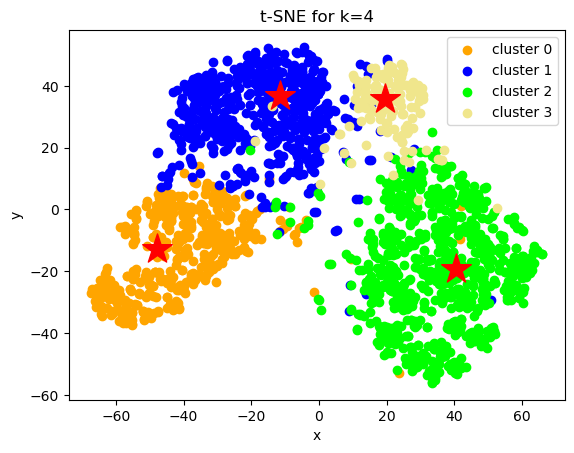

In [63]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_,
                       centers=XYcoordinates[-k:,:], 
                       title=f't-SNE for k={k}')

In [69]:
df_pre['cluster'] = pd.Series(clustering_model['kMeans'].labels_, index=df.index)

In [70]:
df_pre.describe()

age    education      default       balance      housing  \
count  1988.000000  1896.000000  2000.000000   2000.000000  2000.000000   
mean     41.753018     2.246308     0.007500   1413.663500     0.481500   
std      12.724358     0.644020     0.086299   3131.224213     0.499783   
min      18.000000     1.000000     0.000000   -980.000000     0.000000   
25%      32.000000     2.000000     0.000000    201.500000     0.000000   
50%      38.000000     2.000000     0.000000    551.000000     0.000000   
75%      50.000000     3.000000     0.000000   1644.500000     1.000000   
max      93.000000     3.000000     1.000000  81204.000000     1.000000   

              loan     duration     campaign        pdays     previous  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean      0.125000   292.020500     1.909500   167.896000     2.561500   
std       0.330802   221.557295     1.378862   131.754126     3.400735   
min       0.000000     7.000000     1.000000    -1.000000     0.000000   
25%       0.000000   146.000000     1.000000    75.750000     1.000000   
50%       0.000000   236.000000     1.000000   182.000000     2.000000   
75%       0.000000   379.000000     2.000000   251.000000     3.000000   
max       1.000000  1823.000000    11.000000   854.000000    55.000000   

        subscribed    month_sin     month_cos      day_sin      day_cos  \
count  2000.000000  2000.000000  2.000000e+03  2000.000000  2000.000000   
mean      0.500000     0.218295 -7.347338e-02     0.182234     0.068423   
std       0.500125     0.685899  6.906266e-01     0.723069     0.663145   
min       0.000000    -1.000000 -1.000000e+00    -0.974928    -0.900969   
25%       0.000000    -0.500000 -8.660254e-01    -0.433884    -0.222521   
50%       0.500000     0.500000 -1.836970e-16     0.433884    -0.222521   
75%       1.000000     0.866025  5.000000e-01     0.781831     0.623490   
max       1.000000     1.000000  1.000000e+00     0.974928     1.000000   

           cluster  
count  2000.000000  
mean      1.308500  
std       0.915831  
min       0.000000  
25%       1.000000  
50%       1.000000  
75%       2.000000  
max       3.000000

In [71]:
df_pre.tail()

age           job  marital  education  default  balance  housing  loan  \
1995  20.0       student   single        NaN        0     2785        0     0   
1996  28.0        admin.   single        2.0        0      127        0     0   
1997  81.0       retired  married        1.0        0     1154        0     0   
1998  46.0      services  married        1.0        0     4343        1     0   
1999  40.0  entrepreneur  married        2.0        0     6403        0     0   

        contact  duration  campaign  pdays  previous poutcome  subscribed  \
1995   cellular       327         2     -1         0      NaN           1   
1996   cellular      1334         2     -1         0      NaN           1   
1997  telephone       231         1     -1         0      NaN           1   
1998        NaN       185         1     -1         0      NaN           1   
1999   cellular       208         2     -1         0      NaN           1   

      month_sin     month_cos   day_sin   day_cos  cluster  
1995       -1.0 -1.836970e-16  0.974928 -0.222521        0  
1996       -1.0 -1.836970e-16  0.974928 -0.222521        0  
1997       -1.0 -1.836970e-16  0.433884 -0.900969        0  
1998       -1.0 -1.836970e-16 -0.781831  0.623490        0  
1999       -1.0 -1.836970e-16  0.781831  0.623490        0

In [72]:
df_pre.groupby('cluster').mean()

C:\Users\KOFarre1\AppData\Local\Temp\ipykernel_36464\3662424905.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pre.groupby('cluster').mean()


age  education   default      balance   housing      loan  \
cluster                                                                    
0        39.401674   2.223714  0.008351  1323.640919  0.411273  0.068894   
1        44.714789   2.328996  0.000000  2027.267951  0.187391  0.040280   
2        41.494975   2.179355  0.012438   996.338308  0.747512  0.235075   
3        39.335616   2.375000  0.006849  1607.376712  0.397260  0.034247   

           duration  campaign       pdays  previous  subscribed  month_sin  \
cluster                                                                      
0        339.279749  1.789144    2.734864  0.118998    0.613779   0.144944   
1        358.656743  1.905429  150.742557  4.129597    0.964974  -0.246708   
2        204.365672  2.021144  226.839552  2.851990    0.023632   0.663430   
3        359.061644  1.705479  452.253425  2.842466    0.931507  -0.173740   

         month_cos   day_sin   day_cos  
cluster                                 
0        -0.588945  0.302084  0.276042  
1        -0.397380  0.018027  0.063664  
2         0.538553  0.258117 -0.046707  
3        -0.485858  0.013355  0.039872